In [0]:
import pandas as pd
#import quandl
import numpy as np
#import quandl
import matplotlib.pyplot as plt
import os
import math
#import talib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from sklearn.metrics import accuracy_score
import seaborn as sns
import operator
import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(20, 8), dpi=100)
from datetime import datetime

C:\Users\56284\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
pd.options.display.max_columns = None

In [0]:

data = pd.read_excel("GoldmanSachs_Final.xlsx")
print('Total dataset has {} days, and {} features.'.format(data.shape[0], \
                                                              data.shape[1]))
df = data.copy()
#df_clf = data.copy()
del df['Date']
del df['Earning_Surprise_0.05']
del df['Earning_Surprise_0.1']
del df['Earning_Surprise_0.15']

Total dataset has 4986 days, and 356 features.


In [0]:
candidates =  {'Return on Assets (%)':[],
 'Return on Equity (%)':[],
 'Efficiency Ratio (%)':[],
 'Price/Earnings':[],
 'Price/Book Value':[],
 'Dividend Yield (%)':[],
 'EPS (diluted)': ['EPS (recurring)'],
 'Dividends per Share_x': ['Dividends per Share_y'],
 'Book Value per Share_x': ['Book Value per Share_y'],
 'Dividend Payout Ratio (%)': [],
 'Cash & Secs/Deposits': [],
 'Invested Assets+Loans/Deposits (%)': [],
 'Tier 1 Risk Based Capital Ratio (%)': [],
 'Total Capital Adequacy Ratio (%)': [],
 'Free Cash Flow per Share': ['Free Cash Flow_x', 'Free Cash Flow Yield (%)', 'Free Cash Flow_y']
}

In [0]:
candidates = {'Dividends per Share_x': ['Dividends per Share_y'],'Free Cash Flow per Share': ['Free Cash Flow_x', 'Free Cash Flow Yield (%)', 'Free Cash Flow_y']}

In [0]:
candidates = {'Free Cash Flow per Share': ['Free Cash Flow_x', 'Free Cash Flow Yield (%)', 'Free Cash Flow_y']}

Return on Assets (%) 0.09413989010748984
Return on Assets (%) 0.7867498762295607
Return on Equity (%) 1.4849660566207137
Return on Equity (%) 0.5631032379634308
Efficiency Ratio (%) 3.4596233553282
Efficiency Ratio (%) -0.3782365440043953
Price/Earnings 4.9752739033194935
Price/Earnings 0.09695295675645699
Price/Book Value 0.05662693745428876
Price/Book Value 0.8816901298553861
Dividend Yield (%) 0.27775584452736696
Dividend Yield (%) -0.3859682396354527
EPS (diluted) 3.4078966468044034
EPS (diluted) 0.4967849227731592
Dividends per Share_x 0.7623531117316524
Dividends per Share_x -4.960894187063268
Book Value per Share_x 31.613659638166332
Book Value per Share_x -3.9446161596278984
Dividend Payout Ratio (%) 4.963403846582706
Dividend Payout Ratio (%) 0.4034964894293772
Cash & Secs/Deposits 389.28071049685155
Cash & Secs/Deposits -6.731802258869273
Invested Assets+Loans/Deposits (%) 261.0449023154073
Invested Assets+Loans/Deposits (%) -2.978209721439701
Tier 1 Risk Based Capital Ratio 

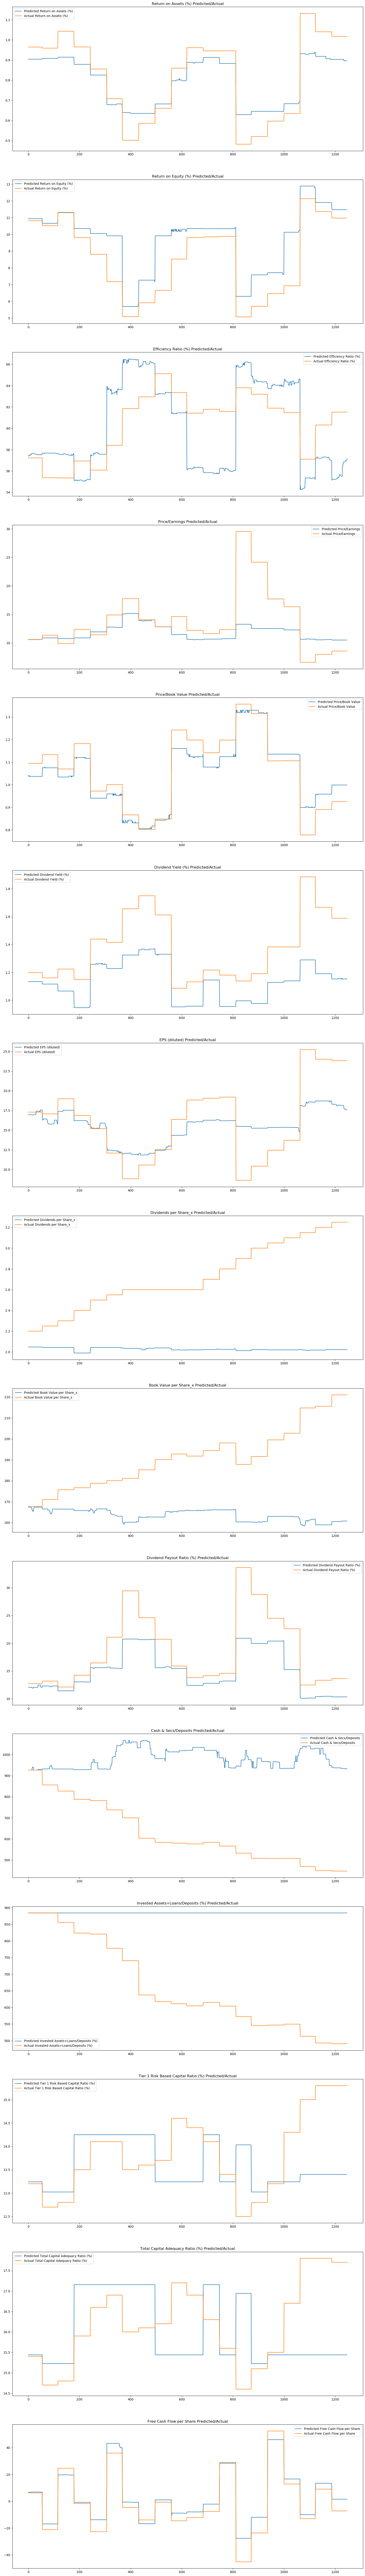

In [0]:
class Model:
    def __init__(self, X_train, Y_train, X_test, Y_test):
        
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
    
    def trainModel(self, epoch = 1000, verbose_flag = False, learning_rate = 0.01):
        
        regressor = xgb.XGBRegressor(colsample_bytree = 0.4, learning_rate = learning_rate, base_score=0.65, max_depth = 4, alpha = 10, n_estimators = epoch)
        xgbModel=regressor.fit(X_train, Y_train,eval_set = [(X_train, Y_train), (X_test, Y_test)], verbose = verbose_flag)
        return (xgbModel, regressor)
    
def getData(data_temp, candidate, inc_analyst):

    data = data_temp.copy()
    if candidates[candidate]:
        Y = data[candidate]
        del data[candidate]
        for i in candidates[candidate]:
            del data[i]
        X = data
    else:
        Y = data[candidate]
        del data[candidate]  
        X = data
        
    train_samples = int(X.shape[0] * 0.75)

    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    Y_train = Y.iloc[:train_samples]
    Y_test = Y.iloc[train_samples:]


    return (X_train, Y_train), (X_test, Y_test)

def featureReduction(feature_importance):

    f = dict()
    n = len(feature_importance)
    for i in range (n):
        f[X_test.columns[i]] = feature_importance[i]
    f = sorted(f.items(), key=operator.itemgetter(1), reverse=True)
    feature_name = list()
    feature_values = list()
    for i, j in f:
        feature_name.append(i)
        feature_values.append(j)

    return feature_name, feature_values

def gridSearch(X_train, Y_train, params):
    regressor = xgb.XGBRegressor(n_thread = -1)
    grid = GridSearchCV(regressor,params, 'r2' ,-1)
    #fit_params={"early_stopping_rounds":10, 
         #   "eval_metric" : "rmse", 
         #   "eval_set" : [[X_train, Y_train]]}
    grid.fit(X_train, Y_train)
    return grid.best_params_
    
fig, ax = plt.subplots(len(candidates),1,figsize = (20,150))

i = 0
for candidate in candidates:

    (X_train, Y_train), (X_test, Y_test) = getData(df, candidate, inc_analyst = True)

    m1 = Model(X_train, Y_train ,X_test, Y_test)
    xgbModel1, regressor1 = m1.trainModel()
    feature_importance = xgbModel1.feature_importances_.tolist()
    feature_sorted, _ = featureReduction(feature_importance)
    df_temp = df.copy()

    n_features_to_keep = 40
    for f in feature_sorted[n_features_to_keep:-1]:
        for col in df_temp.columns:
            if col == f:
                del df_temp[col]
                


    (X_train, Y_train), (X_test, Y_test) = getData(df_temp, candidate, inc_analyst=False)

    param = {'min_child_weight' : [i for i in range(1,4)],'gamma' : [i for i in range(1,4)], 'colsample_bytree' : [i/10 for i in range(3,8)],'max_depth' : [3,4,5],
             'n_estimators' : [1000] , 'learning_rate' : [0.05]}
    best_min_child_weight = gridSearch(X_train, Y_train, param)

    regressor = xgb.XGBRegressor(**best_min_child_weight)
    xgbModel=regressor.fit(X_train, Y_train,eval_set = [(X_train, Y_train), (X_test, Y_test)], verbose = False)

    y_pred = regressor.predict(X_test)
    ax[i].plot(range(len(y_pred)), y_pred, label = f"Predicted {candidate}")  
    ax[i].plot(range(len(Y_test)), Y_test, label = f"Actual {candidate}") 
    ax[i].legend()
    ax[i].set_title(f'{candidate} Predicted/Actual')
    r2score = r2_score(Y_test,y_pred)
    
    print(candidate, math.sqrt(mean_squared_error(Y_test, y_pred)))
    print(candidate, r2score)
    i+=1